# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/train.csv")
test_df = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/test.csv")

display(df.head())
display(df.info())

texts = df['text'].to_list()
labels = df[['anger', 'fear', 'joy', 'sadness', 'surprise']].to_numpy(dtype=np.float32)

id                                               text  anger  fear  joy  \
0   0  the dentist that did the work apparently did a...      1     0    0   
1   1  i'm gonna absolutely ~~suck~~ be terrible duri...      0     1    0   
2   2  bridge: so leave me drowning calling houston, ...      0     1    0   
3   3  after that mess i went to see my now ex-girlfr...      1     1    0   
4   4  as he stumbled i ran off, afraid it might some...      0     1    0   

   sadness  surprise                    emotions  
0        1         0         ['anger' 'sadness']  
1        1         0          ['fear' 'sadness']  
2        1         0          ['fear' 'sadness']  
3        1         0  ['anger' 'fear' 'sadness']  
4        0         0                    ['fear']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6827 entries, 0 to 6826
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6827 non-null   int64 
 1   text      6827 non-null   object
 2   anger     6827 non-null   int64 
 3   fear      6827 non-null   int64 
 4   joy       6827 non-null   int64 
 5   sadness   6827 non-null   int64 
 6   surprise  6827 non-null   int64 
 7   emotions  6827 non-null   object
dtypes: int64(6), object(2)
memory usage: 426.8+ KB


None

In [2]:
TRAIN_MODE   = 1
PRED_MODE    = 1 # Predication Mode 
EPOCHS       = 500
MODEL_TYPE   = 1 # 0 -> RNN model; 1 -> Custom Model; 2 -> Fine Tune Model
UPLOAD_MODEL = 0 # upload model to hugging face.
USE_MODEL    = 0 # use hugging face model.
USE_WANDB    = 1

NUM_LABELS   = 5
PROJECT      = "23f2003807-t32025"
TEAM_ENTITY  = "jashmevada1610-iit-madras"
WANDB_RUN_NAME = "custom-model-2"

# Hugging Face
branch       = "custom-model"
repo_id      = "JashMevada/emotion-classifier"
commit_msg   = "init"

In [3]:
%%capture
!pip install pytorch-lightning iterative-stratification protobuf==4.25.8 

In [4]:
import wandb
import os
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import TensorBoardLogger
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

logger =  TensorBoardLogger("logs/")

if USE_WANDB == 1 and TRAIN_MODE == 1:
    wandb_key = user_secrets.get_secret("wandb_api_key")
    wandb.login(key=wandb_key)
    logger = WandbLogger(name=WANDB_RUN_NAME, project=PROJECT, entity=TEAM_ENTITY, log_model="all")

if UPLOAD_MODEL == 1 or USE_MODEL == 1:
    os.environ["HF_TOKEN"] = user_secrets.get_secret("HF_TOKEN")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# EDA

## Label Distribution and Number of Labels per Text

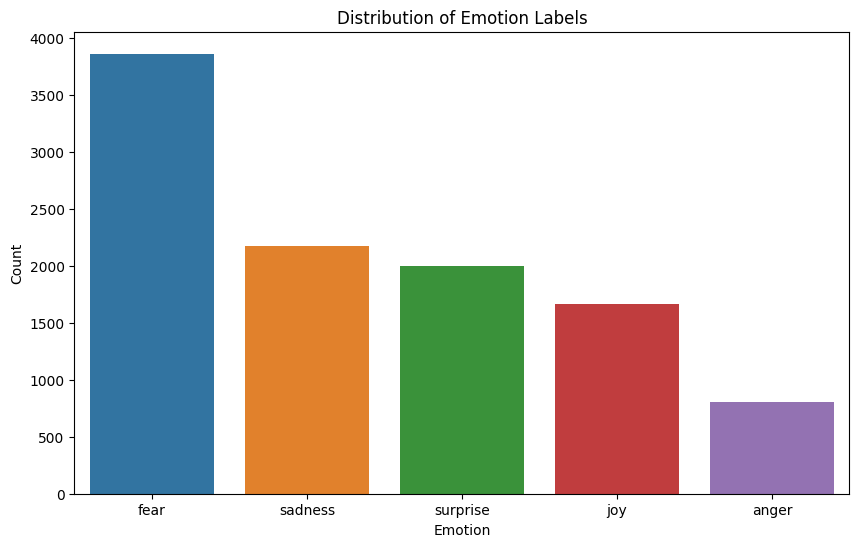

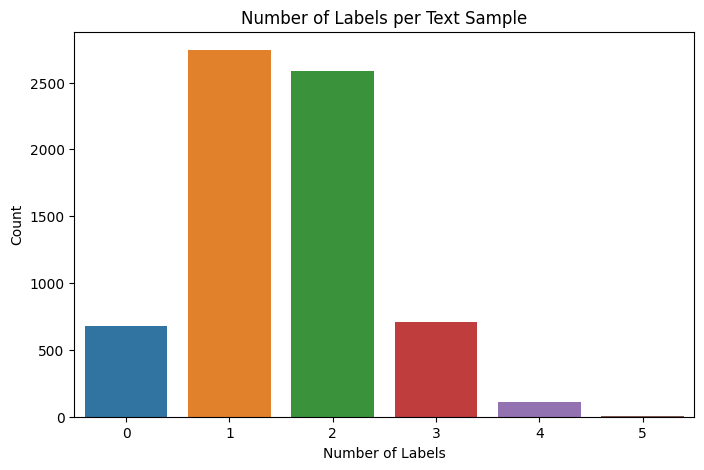

In [5]:
emotion_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
label_counts = df[emotion_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

df['label_count'] = df[emotion_cols].sum(axis=1)

plt.figure(figsize=(8, 5))
sns.countplot(x='label_count', data=df)
plt.title('Number of Labels per Text Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Count')
plt.show()

## Correlation Matrix

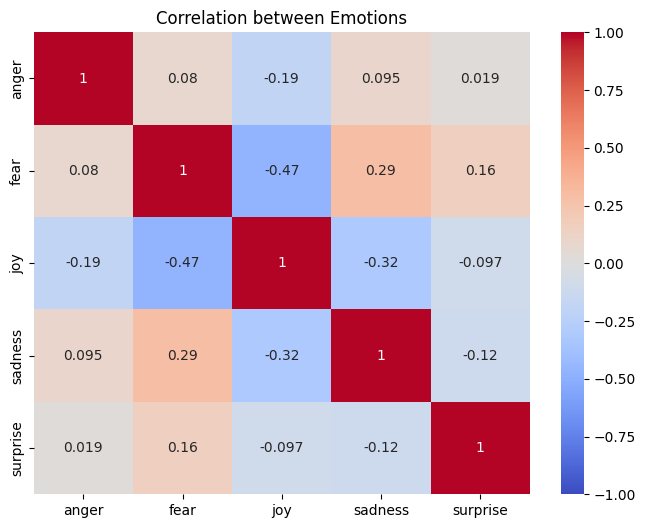

In [6]:
plt.figure(figsize=(8, 6))
corr_matrix = df[emotion_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Emotions')
plt.show()

## Text Length Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


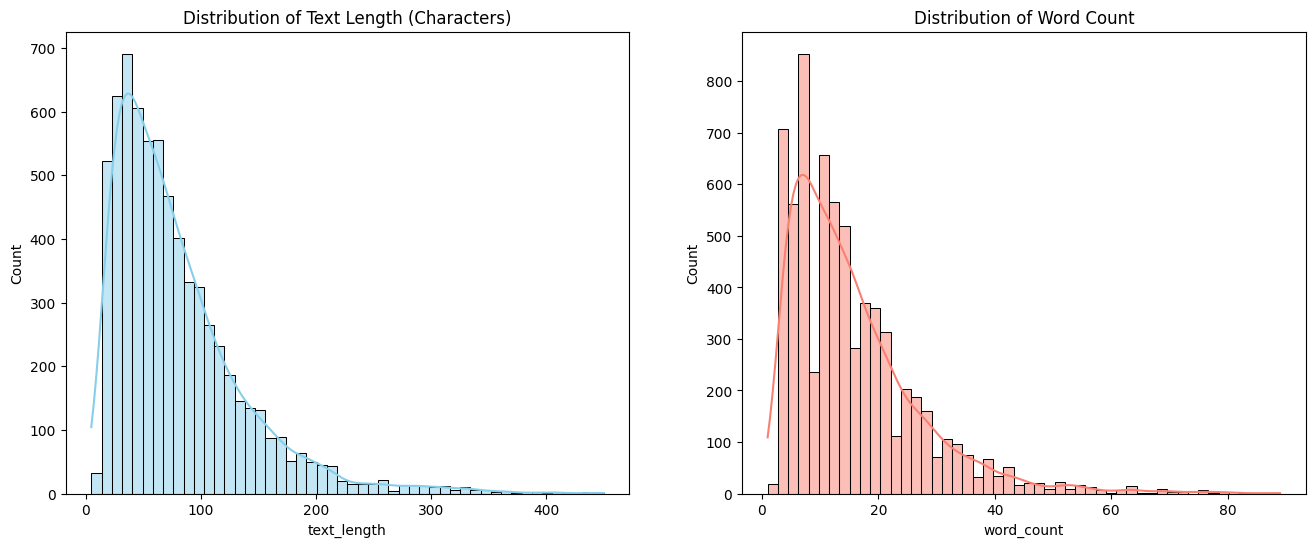

In [7]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['text_length'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Text Length (Characters)')

sns.histplot(df['word_count'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Word Count')

plt.show()

## Word Clouds

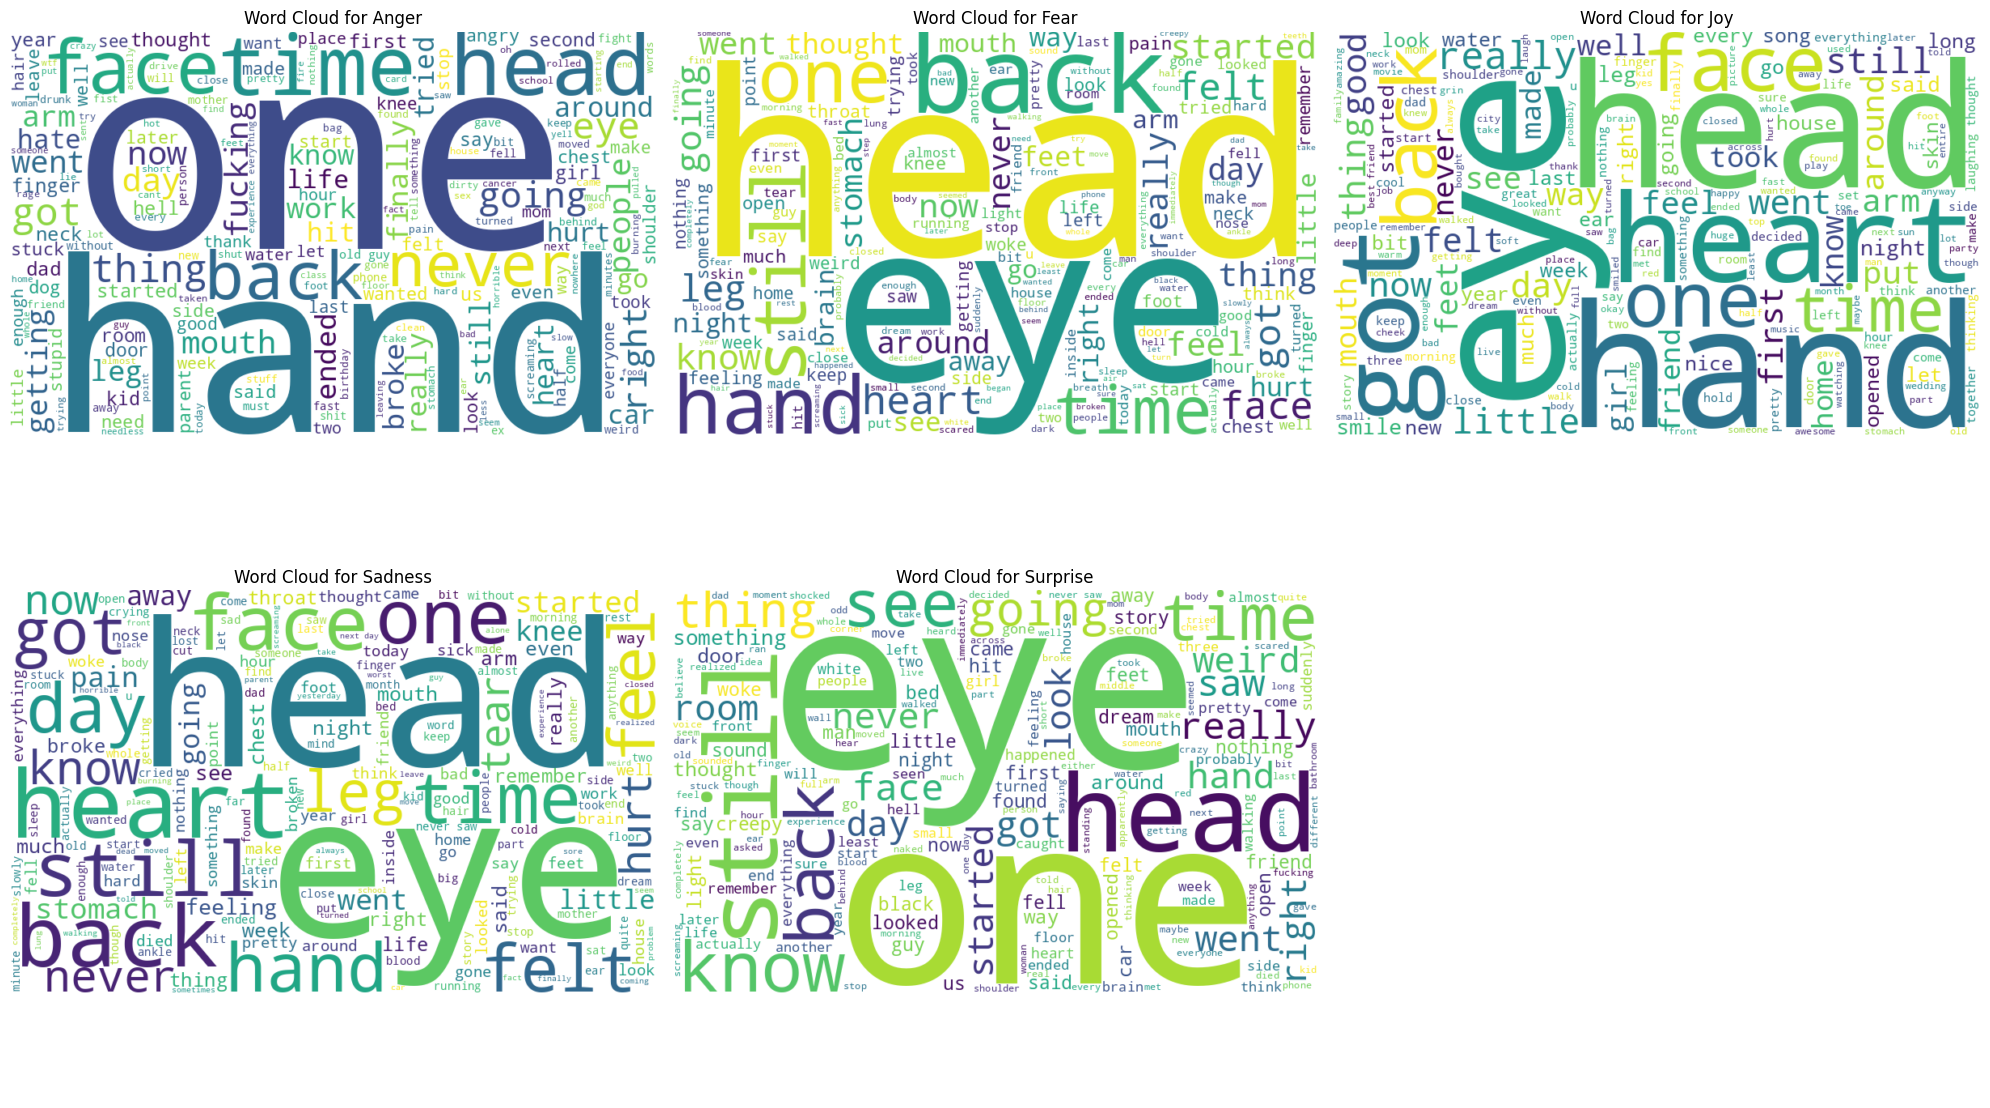

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, emotion in enumerate(emotion_cols):
    subset = df[df[emotion] == 1]
    # Join all text for this emotion
    text = ' '.join(subset['text'].astype(str).tolist())

    if len(text) > 0:
        wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud for {emotion.capitalize()}')
    else:
        axes[i].text(0.5, 0.5, "No Data", ha='center', va='center')

    axes[i].axis('off')

# Hide the last subplot if unused
if len(emotion_cols) < 6:
    for j in range(len(emotion_cols), 6):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

# Dataset Setup for Pytorch

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping 
import torchmetrics
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

class EmotionDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128, indices=None, has_labels=True):
        if indices is not None:
            self.texts = [texts[i] for i in indices]
            if labels is not None and has_labels:
                self.labels = labels[indices]
            else:
                self.labels = None 
        else:
            self.texts = texts
            if labels is not None and has_labels:
                self.labels = labels
            else:
                self.labels = None 
        self.tok = tokenizer
        self.max_length = max_length
        self.has_labels = has_labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        t = self.texts[i]
        enc = self.tok(
            t, padding="max_length", truncation=True,
            max_length=self.max_length, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        if self.has_labels and self.labels is not None:
            y = self.labels[i]
            item["labels"] = torch.tensor(y, dtype=torch.float32)
        return item

class EmotionDataModule(pl.LightningDataModule):
    def __init__(self, texts, labels, tokenizer, batch_size=32, max_length=128, train_split=0.8,
                 test_texts=None, test_ids=None, random_state=42): 
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.train_split = train_split
        self.test_texts = test_texts
        self.test_ids = test_ids 
        self.random_state = random_state
        
    def setup(self, stage=None):
        num_samples = len(self.texts)
        train_size = int(num_samples * self.train_split)

        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=1-self.train_split, random_state=self.random_state)
        
        for train_index, val_index in msss.split(np.zeros(num_samples), self.labels):
            train_indices = train_index
            val_indices = val_index
            
        self.train_dataset = EmotionDataset(
            self.texts, self.labels, self.tokenizer, self.max_length, indices=train_indices, has_labels=True
        )
        self.val_dataset = EmotionDataset(
            self.texts, self.labels, self.tokenizer, self.max_length, indices=val_indices, has_labels=True
        )

        if self.test_texts is not None:
            self.test_dataset = EmotionDataset(
                self.test_texts, labels=None, tokenizer=self.tokenizer, max_length=self.max_length, has_labels=False
            )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        if hasattr(self, 'test_dataset'):
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
        else:
            raise AttributeError("Test dataset not initialized. Please provide test_texts to the DataModule.")

In [10]:
MODEL_NAME = "distilbert-base-uncased" #"FacebookAI/roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

data_module = EmotionDataModule(
    texts=texts,
    labels=labels,
    tokenizer=tokenizer,
    batch_size=16,
    max_length=256,
    test_texts=test_df['text'].to_list()
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# RNN-Based Model

In [ ]:
class RNNEmotionModel(pl.LightningModule):
    """
    A Recurrent Neural Network (RNN) based model for emotion classification.
    
    Architecture:
    1. Embedding Layer: Converts input token IDs into dense vector representations.
    2. Bidirectional LSTM: Processes the sequence of embeddings to capture context 
       from both past and future tokens.
    3. Classification Head: A Fully Connected (Dense) layer that maps the final 
       hidden state to the emotion classes.
    """
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=256, num_layers=2, 
                 num_labels=NUM_LABELS, learning_rate=1e-3, dropout=0.3, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        
        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        
        # 2. RNN Layer (Bidirectional LSTM)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 3. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )
        
        # Loss and Metrics
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)
        else:
            self.criterion = nn.BCEWithLogitsLoss()
            
        self.f1_metric = torchmetrics.classification.MultilabelF1Score(
            num_labels=num_labels, average="macro", threshold=0.5
        )

    def forward(self, input_ids, attention_mask=None):
        # input_ids shape: (batch_size, seq_len)
        embeds = self.embedding(input_ids)
        
        # lstm_out, (hidden, cell) = self.lstm(embeds)
        _, (hidden, _) = self.lstm(embeds)
        
        # Concatenate the final forward and backward hidden states.
        # hidden[-2, :, :] is the last layer's forward state
        # hidden[-1, :, :] is the last layer's backward state
        final_hidden_state = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        
        logits = self.classifier(final_hidden_state)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        labels = batch["labels"]

        logits = self(input_ids)
        loss = self.criterion(logits, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        labels = batch["labels"]

        logits = self(input_ids)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.f1_metric.update(probs, labels)

    def on_validation_epoch_end(self):
        f1_score = self.f1_metric.compute()
        self.log("val_macroF1", f1_score, on_epoch=True, prog_bar=True, logger=True)
        self.f1_metric.reset()
        
    def predict_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        logits = self(input_ids)
        probs = torch.sigmoid(logits)
        return probs

    @torch.no_grad()
    def predict(
        self, texts, tokenizer: AutoTokenizer, max_length: int = 256, batch_size: int = 32
    ):
        was_training = self.training
        self.eval()
        encodings = tokenizer(
            list(texts),
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        input_ids = encodings["input_ids"].to(self.device)
        outputs = []
        for start in range(0, input_ids.size(0), batch_size):
            end = start + batch_size
            logits = self(input_ids[start:end])
            outputs.append(torch.sigmoid(logits).cpu())
        if was_training:
            self.train()
        return torch.cat(outputs, dim=0).numpy()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


# Custom Deep Learning Model

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, List, Optional, Sequence

@dataclass
class TextCNNConfig:
    vocab_size: int
    num_labels: int = 5
    embed_dim: int = 600
    kernel_sizes: Sequence[int] = (3, 4, 5)
    num_filters: int = 256
    dropout: float = 0.3
    learning_rate: float = 1e-3
    class_weights: Optional[torch.Tensor] = None


class TextCNNEmotionModel(pl.LightningModule):
    """Multi-label Text-CNN with multiple convolution kernel sizes."""

    def __init__(self, config: TextCNNConfig) -> None:
        super().__init__()
        self.save_hyperparameters(config.__dict__)

        self.embedding = nn.Embedding(config.vocab_size, config.embed_dim, padding_idx=1)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=config.embed_dim,
                    out_channels=config.num_filters,
                    kernel_size=kernel_size,
                    padding="valid",
                )
                for kernel_size in config.kernel_sizes
            ]
        )
        self.dropout = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.num_filters * len(config.kernel_sizes), config.num_labels)

        if config.class_weights is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=config.class_weights)
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        self.f1_metric = torchmetrics.classification.MultilabelF1Score(
            num_labels=config.num_labels,
            average="macro",
            threshold=0.5,
        )

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        del attention_mask  # not used in this architecture
        x = self.embedding(input_ids)  # (B, T, E)
        x = x.transpose(1, 2)  # (B, E, T)

        conv_results: List[torch.Tensor] = []
        for conv in self.convs:
            activated = torch.relu(conv(x))
            pooled = torch.max(activated, dim=2).values  # global max pool
            conv_results.append(pooled)

        features = torch.cat(conv_results, dim=1)
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits

    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        logits = self(batch["input_ids"], batch.get("attention_mask"))
        loss = self.criterion(logits, batch["labels"])
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: dict, batch_idx: int) -> None:
        logits = self(batch["input_ids"], batch.get("attention_mask"))
        loss = self.criterion(logits, batch["labels"])
        probs = torch.sigmoid(logits)
        self.f1_metric.update(probs, batch["labels"])
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self) -> None:
        f1_value = self.f1_metric.compute()
        self.log("val_macroF1", f1_value, prog_bar=True)
        self.f1_metric.reset()

    def predict_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        logits = self(batch["input_ids"], batch.get("attention_mask"))
        probs = torch.sigmoid(logits)
        return probs

    @torch.no_grad()
    def predict(
        self, texts, tokenizer: AutoTokenizer, max_length: int = 256, batch_size: int = 32
    ):
        was_training = self.training
        self.eval()
        encodings = tokenizer(
            list(texts),
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        input_ids = encodings["input_ids"].to(self.device)
        attention_mask = encodings.get("attention_mask")
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        outputs = []
        for start in range(0, input_ids.size(0), batch_size):
            end = start + batch_size
            logits = self(
                input_ids[start:end],
                attention_mask[start:end] if attention_mask is not None else None,
            )
            outputs.append(torch.sigmoid(logits).cpu())
        if was_training:
            self.train()
        return torch.cat(outputs, dim=0).numpy()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        train_loader = self.trainer.datamodule.train_dataloader()
        steps_per_epoch = len(train_loader)
        total_steps = steps_per_epoch * self.trainer.max_epochs
        warmup_steps = int(0.1 * total_steps)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

# Fine Tune Model

In [ ]:
class FineTuneModel(pl.LightningModule):
    def __init__(self, model_name=MODEL_NAME, num_labels=NUM_LABELS, learning_rate=2e-5, weight_decay=1e-2, class_weights=None, label_smoothing=0.05):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = AutoModel.from_pretrained(model_name,add_pooling_layer=False)
        hidden = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, num_labels),
        )
        
        self.label_smoothing = label_smoothing
        
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        self.f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels=num_labels, average="macro", threshold=0.5)

    def _smooth_labels(self, labels):
        if self.label_smoothing <= 0.0:
            return labels
        eps = self.label_smoothing
        return labels * (1 - eps) + 0.5 * eps
        
    
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        last_hidden = out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        summed = (last_hidden * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-9)
        pooled = summed / counts
        
        logits = self.classifier(self.dropout(pooled))
        
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        labels_smoothed = self._smooth_labels(labels)
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels_smoothed)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.f1_metric.update(probs, labels)

    def on_validation_epoch_end(self):
        f1_score = self.f1_metric.compute()
        self.log("val_macroF1", f1_score, on_epoch=True, prog_bar=True, logger=True)
        self.f1_metric.reset()

    def predict_step(self, batch, batch_idx): 
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        logits = self(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        return probs

    @torch.no_grad()
    def predict(
        self, texts, tokenizer: AutoTokenizer, max_length: int = 256, batch_size: int = 32
    ):
        was_training = self.training
        self.eval()
        encodings = tokenizer(
            list(texts),
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        input_ids = encodings["input_ids"].to(self.device)
        attention_mask = encodings.get("attention_mask")
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        outputs = []
        for start in range(0, input_ids.size(0), batch_size):
            end = start + batch_size
            logits = self(
                input_ids[start:end],
                attention_mask[start:end] if attention_mask is not None else None,
            )
            outputs.append(torch.sigmoid(logits).cpu())
        if was_training:
            self.train()
        return torch.cat(outputs, dim=0).numpy()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        train_loader = self.trainer.datamodule.train_dataloader()
        steps_per_epoch = len(train_loader)
        total_steps = steps_per_epoch * self.trainer.max_epochs
        warmup_steps = int(0.1 * total_steps)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

In [14]:
data_module.setup(stage='fit')

class_counts = np.zeros(NUM_LABELS)

for item in data_module.train_dataset:
    labels_tensor = item['labels']
    class_counts += labels_tensor.numpy()

total_train_samples = len(data_module.train_dataset)

class_frequencies = class_counts / total_train_samples

epsilon = 1e-8 
inverse_frequencies = 1 / (class_frequencies + epsilon)


min_inv_freq = np.min(inverse_frequencies)
if min_inv_freq == 0:

    class_weights = np.ones(NUM_LABELS)
else:
    class_weights = inverse_frequencies / min_inv_freq

pos_counts = class_counts
neg_counts = total_train_samples - class_counts

epsilon = 1e-8
pos_weight = neg_counts / (pos_counts + epsilon)

class_weights_tensor = torch.tensor(pos_weight, dtype=torch.float32)

print("Positive counts:", pos_counts)
print("Negative counts:", neg_counts)
print("pos_weight for BCEWithLogitsLoss:", class_weights_tensor)

Positive counts: [ 646. 3088. 1328. 1737. 1599.]
Negative counts: [4815. 2373. 4133. 3724. 3862.]
pos_weight for BCEWithLogitsLoss: tensor([7.4536, 0.7685, 3.1122, 2.1439, 2.4153])


# Train Model

In [15]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# RNN Model
if MODEL_TYPE == 0:
    vocab_size = tokenizer.vocab_size
    model = RNNEmotionModel(vocab_size=vocab_size)

    early_stopping = pl.callbacks.EarlyStopping(
        monitor="val_macroF1", mode="max", patience=3,verbose=True
    )
    
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        logger=logger,
        callbacks=[early_stopping],
        accelerator="auto",
        enable_checkpointing=False
    )



# Custom Model
if MODEL_TYPE == 1:
    config = TextCNNConfig(
        vocab_size=tokenizer.vocab_size,
        class_weights=class_weights_tensor,
    )
    
    model = TextCNNEmotionModel(config)

    trainer = pl.Trainer(
        max_epochs=EPOCHS, 
        logger=logger,
        accelerator="auto",
        callbacks=[EarlyStopping(monitor="val_macroF1", mode="max", patience=3,verbose=True)]
    )


# Fine Tune
if MODEL_TYPE == 2: 
    model = FineTuneModel(
        model_name=MODEL_NAME,
        num_labels=NUM_LABELS,
        learning_rate=2e-5, #2e-5
        weight_decay=1e-2,
        class_weights=class_weights_tensor
    )
    
    trainer = pl.Trainer(
        max_epochs=EPOCHS, 
        logger=logger,
        accelerator="auto",
        callbacks=[EarlyStopping(monitor="val_macroF1", mode="max", patience=3,verbose=True)],
        enable_checkpointing=False
    )

def train(model, trainer):
    print("Begin Training...")
    
    logger.experiment.config["max_epochs"] = trainer.max_epochs
    trainer.fit(model, data_module)

if TRAIN_MODE: train(model, trainer)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Begin Training...


wandb: creating run
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251127_180403-o4fo2klk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run custom-model-2
wandb: ⭐️ View project at https://wandb.ai/jashmevada1610-iit-madras/23f2003807-t32025
wandb: 🚀 View run at https://wandb.ai/jashmevada1610-iit-madras/23f2003807-t32025/runs/o4fo2klk
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | embedding  | Embedding         | 18.3 M | train
1 | convs      | ModuleList        | 1.8 M  | train
2 | dropout    | Dropout           | 0      | train
3 | classifier | Linear            | 3.8 K  | train
4 | criterion  | BCEWithLogitsLoss | 0      | train
5 | f1_metric  | MultilabelF1Score | 0      | train
---------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved. New best score: 0.482
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARA

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.094 >= min_delta = 0.0. New best score: 0.576
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.100 >= min_delta = 0.0. New best score: 0.677
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.022 >= min_delta = 0.0. New best score: 0.698
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.005 >= min_delta = 0.0. New best score: 0.703
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.013 >= min_delta = 0.0. New best score: 0.716
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_macroF1 improved by 0.001 >= min_delta = 0.0. New best score: 0.717
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_macroF1 did not improve in the last 3 records. Best score: 0.717. Signaling Trainer to stop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicting: |          | 0/? [00:00<?, ?it/s]


Average Precision (AP) scores for each emotion with weighted loss:
  anger: 0.6662
  fear: 0.9008
  joy: 0.7653
  sadness: 0.8184
  surprise: 0.8347

Precision-Recall curve data and AP scores calculated and stored for the weighted model.


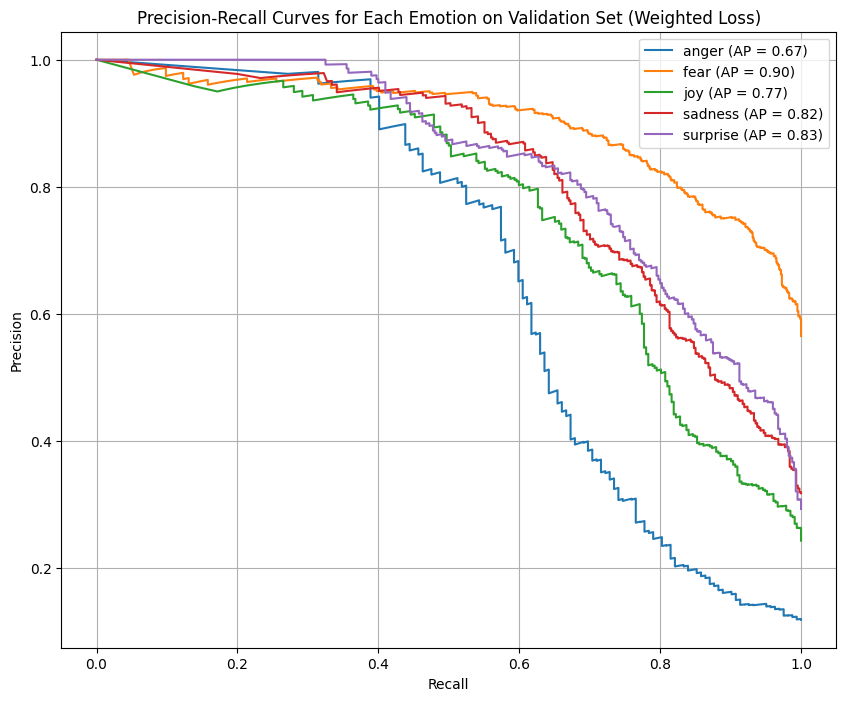

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

data_module.setup(stage="fit")

val_true_labels = np.array([item['labels'].numpy() for item in data_module.val_dataset])

model.eval()

val_predictions_batches_weighted = trainer.predict(model, dataloaders=data_module.val_dataloader())
val_probabilities_weighted = torch.cat(val_predictions_batches_weighted, dim=0)
val_probabilities_weighted_np = val_probabilities_weighted.cpu().numpy()

emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

pr_curves_data_weighted = {}

print("\nAverage Precision (AP) scores for each emotion with weighted loss:")

for i, emotion in enumerate(emotion_labels):
    y_true = val_true_labels[:, i]
    y_scores = val_probabilities_weighted_np[:, i]

    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    ap_score = average_precision_score(y_true, y_scores)

    pr_curves_data_weighted[emotion] = {
        'precision': precision,
        'recall': recall,
        'ap_score': ap_score
    }

    print(f"  {emotion}: {ap_score:.4f}")

print("\nPrecision-Recall curve data and AP scores calculated and stored for the weighted model.")

plt.figure(figsize=(10, 8))

for emotion, data in pr_curves_data_weighted.items():
    plt.plot(
        data['recall'],
        data['precision'],
        label=f'{emotion} (AP = {data["ap_score"]:.2f})'
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Emotion on Validation Set (Weighted Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.eval()
data_module.setup(stage="fit")

val_true_labels = np.array([item['labels'].numpy() for item in data_module.val_dataset])
val_predictions_batches_weighted = trainer.predict(model, dataloaders=data_module.val_dataloader())
val_probabilities_weighted = torch.cat(val_predictions_batches_weighted, dim=0)
val_probabilities_weighted_np = val_probabilities_weighted.cpu().numpy()

optimal_thresholds = {}

for i, emotion in enumerate(emotion_labels):
    y_true = val_true_labels[:, i]
    y_scores = val_probabilities_weighted_np[:, i]

    best_f1 = -1.0
    best_thresh = 0.5

    # coarse search
    for thresh in np.arange(0.05, 1.0, 0.05):
        y_pred_binary = (y_scores >= thresh).astype(int)
        current_f1 = f1_score(y_true, y_pred_binary, average="binary")
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thresh = thresh

    # fine search around best_thresh
    low = max(0.01, best_thresh - 0.05)
    high = min(0.99, best_thresh + 0.05)
    for thresh in np.arange(low, high, 0.01):
        y_pred_binary = (y_scores >= thresh).astype(int)
        current_f1 = f1_score(y_true, y_pred_binary, average="binary")
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thresh = thresh

    optimal_thresholds[emotion] = best_thresh
    print(f"  {emotion}: Optimal Threshold = {best_thresh:.2f} (Max F1 = {best_f1:.4f})")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicting: |          | 0/? [00:00<?, ?it/s]

  anger: Optimal Threshold = 0.97 (Max F1 = 0.6572)
  fear: Optimal Threshold = 0.17 (Max F1 = 0.8153)
  joy: Optimal Threshold = 0.22 (Max F1 = 0.6987)
  sadness: Optimal Threshold = 0.98 (Max F1 = 0.7299)
  surprise: Optimal Threshold = 0.66 (Max F1 = 0.7436)


In [18]:
from sklearn.metrics import f1_score

binary_predictions_optimized = np.zeros_like(val_true_labels)

for i, emotion in enumerate(emotion_labels):
    thresh = optimal_thresholds[emotion]

    binary_predictions_optimized[:, i] = (val_probabilities_weighted_np[:, i] >= thresh).astype(int)

macro_f1_optimized = f1_score(val_true_labels, binary_predictions_optimized, average='macro')

print(f"\nMacro-F1 score on validation set with optimized thresholds: {macro_f1_optimized:.4f}")


Macro-F1 score on validation set with optimized thresholds: 0.7289


# Submission

In [19]:
import json
from huggingface_hub import upload_folder

def upload_model_hf():
    output_dir = "/kaggle/working/hf_model"
    os.makedirs(output_dir, exist_ok=True)

    tokenizer.save_pretrained(output_dir)
    
    # model.encoder.save_pretrained(output_dir)
    
    torch.save(model.classifier.state_dict(), os.path.join(output_dir, "classifier.pth"))
    print(f"Classifier weights saved to {os.path.join(output_dir, 'classifier.pth')}")
    
    raw_cfg = {
        "model": dict(model.hparams),
        "trainer": {
            "max_epochs": trainer.max_epochs,
            "devices": trainer.num_devices,
            "precision": trainer.precision,
        },
    }
    
    cfg = {
        k: v for k, v in raw_cfg["model"].items()
        if not isinstance(v, torch.Tensor)
    }
    
    print(cfg)
    
    with open(os.path.join(output_dir, "classifier_config.json"), "w") as f:
        json.dump(cfg, f)
    print(f"Classifier config saved to {os.path.join(output_dir, 'classifier_config.json')}")
        
    upload_folder(
        repo_id=repo_id,
        folder_path=output_dir,
        commit_message=commit_msg,
        path_in_repo=".",
        revision=branch
    )
    print(f"Model components uploaded to https://huggingface.co/{repo_id}")

if UPLOAD_MODEL: upload_model_hf()

In [20]:
def create_submission(model, data_module: pl.LightningDataModule, test_df, output_path="submission.csv"):
    test_ids = test_df['id'].to_list()
    
    data_module.setup(stage="test")
    
    model.eval()
    
    test_predictions_batches_weighted = trainer.predict(model, dataloaders=data_module.test_dataloader())
    test_probabilities_weighted = torch.cat(test_predictions_batches_weighted, dim=0)
    test_probabilities_weighted_np = test_probabilities_weighted.cpu().numpy()
    binary_predictions_test = np.zeros_like(test_probabilities_weighted_np, dtype=int)
    
    for i, emotion in enumerate(emotion_labels):
        thresh = optimal_thresholds[emotion]
        binary_predictions_test[:, i] = (test_probabilities_weighted_np[:, i] >= thresh).astype(int)
    
    submission_df = pd.DataFrame(test_ids, columns=['id'])
    
    emotion_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
    
    for i, col in enumerate(emotion_cols):
        submission_df[col] = binary_predictions_test[:, i]
    
    submission_df.to_csv(output_path, index=False)
    
    display(submission_df.head())
    print("Shape: ", submission_df.shape)

if PRED_MODE: create_submission(model, data_module, test_df)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicting: |          | 0/? [00:00<?, ?it/s]

id  anger  fear  joy  sadness  surprise
0   0      0     1    1        0         0
1   1      0     0    0        0         0
2   2      1     1    0        0         0
3   3      0     1    0        0         0
4   4      0     1    0        0         1

Shape:  (1707, 6)
